In [1]:
import torch
import numpy as np
import librosa
import os

In [2]:
# create input audio
sampling_rate = 16000
seq_length = 10 * sampling_rate

filename = librosa.ex('brahms')
print(filename)
audio, sr = librosa.load(filename, sr=sampling_rate)
print('Original audio length (seconds):', len(audio) / sampling_rate)

n_chunk = len(audio) // seq_length
audio_chunks = []
audio_chunks = np.split(audio[: int(n_chunk * seq_length)], n_chunk)
audio_chunks.append(audio[-int(seq_length) :])
audio_chunks = torch.from_numpy(np.array(audio_chunks))
print('Input shape:', audio_chunks.shape)

C:\Users\mikko\AppData\Local\librosa\librosa\Cache\Hungarian_Dance_number_5_-_Allegro_in_F_sharp_minor_(string_orchestra).ogg
Original audio length (seconds): 45.8449375
Input shape: torch.Size([5, 160000])


In [3]:
# create AST model
from models.ASTModel import AST
os.makedirs('../../pretrained_models/', exist_ok=True)
model = AST(n_class=10, reprog_front='skip', map_num=5)
ckpt_path = torch.load('../models/best_model.pth', 'cpu')
model.load_state_dict(ckpt_path)
model.eval()

c:\Users\mikko\miniconda3\envs\music_repro\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\mikko\code\thesis\music-repro\training\models\ASTModel.py:298: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()
c:\Users\mikko\miniconda3\envs\music_repro\lib\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True


c:\Users\mikko\code\thesis\music-repro\training\models\ASTModel.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(


frequncey stride=10, time stride=10
number of patches=1212


C:\Users\mikko\AppData\Local\Temp\ipykernel_7240\215718542.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_path = torch.load('../models/best_model.pth', 'cpu')


AST(
  (ast_mdl): WrappedModel(
    (module): ASTModel(
      (v): DistilledVisionTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (blocks): ModuleList(
          (0-11): 12 x Block(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=768, out_features=768, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (act): GELU(approximate='none')
              (fc2): Linear(in_feature

In [4]:
# predict output
output, ori_emb, transformed_emb = model(audio_chunks)
output = torch.sigmoid(output).detach().cpu().numpy()
ori_emb = ori_emb.detach().cpu().numpy()
transformed_emb = transformed_emb.detach().cpu().numpy()
print(output.shape, ori_emb.shape, transformed_emb.shape)

(5, 10) (5, 768) (5, 768)


In [7]:
# result
mapping = {
            0: "blues",
            1: "classical",
            2: "country",
            3: "disco",
            4: "hiphop",
            5: "jazz",
            6: "metal",
            7: "pop",
            8: "reggae",
            9: "rock",
        }
print(output.mean(0))
idx = np.argmax(output.mean(0), axis=0)
print('This song is predicted as:', mapping[idx])

[0.07163401 0.8644131  0.02506389 0.01448015 0.02296827 0.07746428
 0.02669765 0.18074808 0.06334026 0.00198011]
This song is predicted as: classical


<Figure size 640x480 with 0 Axes>

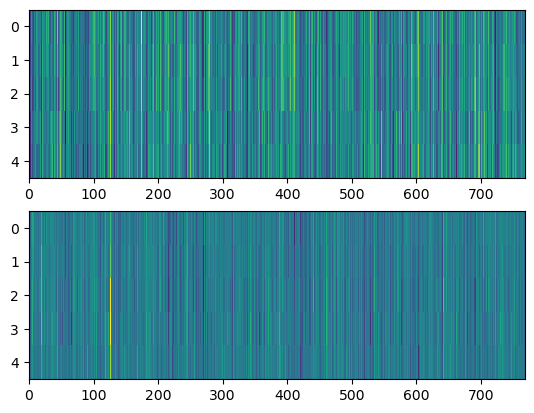

In [8]:
import matplotlib.pyplot as plt

plt.figure()
f, axarr = plt.subplots(2,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ori_emb, interpolation='nearest', aspect='auto')
axarr[1].imshow(transformed_emb, interpolation='nearest', aspect='auto')
